## Cluster chess positions

1. Load positions and labels
2. Embed positions encode labels
3. Scatterplot with PCA / UMAP

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.decomposition import PCA
import chess
import umap

from chesspos.utils.board_bitboard_converter import board_to_bitboard

In [2]:
# step 1
data = pd.read_csv('../data/results.csv', delimiter=';')
data = data.to_numpy()
data.shape

(929, 2)

In [88]:
# step 2 - embedding
encoder_path = "deep64/model_encoder.h5"
encoder = tf.keras.models.load_model(encoder_path)

board = [chess.Board(data[i][0]) for i in range(data.shape[0])]
bb = np.array([board_to_bitboard(board[i]) for i in range(len(board))]).reshape((-1,773))
embeddings = encoder(bb)

print(f"embedding dimension {embeddings[0].shape}")

embedding dimension (64,)


In [89]:
# step 2 - label
labels = [ data[i][1].split(',') for i in range(data.shape[0])]
label_dict = []
# fast pass to get label dictionary
for samp in range(len(labels)):
    for lbl in labels[samp]:
        if lbl not in label_dict:
            label_dict.append(lbl)
label_dict = { s:i for (i,s) in enumerate(label_dict) }
print(f'How many different labels? {len(label_dict)}.')
print(label_dict)

How many different labels? 71.
{'ExposedKing': 0, 'Sacrifice': 1, 'MateThreat': 2, 'Fork/DoubleAttack': 3, 'Zwischenzug': 4, 'Attraction': 5, 'Distraction': 6, 'MatePawn': 7, 'Coercion': 8, 'CapturingDefender': 9, 'Pin': 10, 'Clearance': 11, 'Extrag': 12, 'Overloading': 13, 'Counting': 14, 'DiscoveredAttack': 15, 'HangingPiece': 16, 'MateArabian': 17, 'Skewer': 18, 'UnsoundSacrifice': 19, 'ExtraBxa': 20, 'WeakBackRank': 21, 'DefensiveMove': 22, 'XRayAttack': 23, 'Unpinning': 24, 'DoubleCheck': 25, 'BackRankMate': 26, 'AdvancedPawn': 27, 'TrappedPiece': 28, 'MateOpera': 29, 'MateSmother': 30, 'Blocking': 31, 'MateSuffocation': 32, 'Simplification': 33, "MateDamiano'sBishop": 34, 'MateKillBox': 35, 'DiffKh': 36, 'DiffKf': 37, 'MateDovetail': 38, 'DiffKg': 39, 'Desperado': 40, "MateLolli's": 41, 'MateLawnmower': 42, 'MateDovetailBishop': 43, "MateAnastasia's": 44, "MateGreco's": 45, 'MateDoubleBishop': 46, 'MateHook': 47, 'DiffQd': 48, 'MateVukovic': 49, 'AvoidingPerpetual': 50, 'ExtraBc'

In [90]:
# convert labels to numbers, also count number of occurrences per label
label_count = {key: 0 for key in label_dict.keys()}
num_label = []

for samp in range(len(labels)):
    tmp_numeric = []
    for lbl in labels[samp]:
        tmp_numeric.append(label_dict[lbl])
        label_count[lbl] += 1
    num_label.append(tmp_numeric)
most_common = {k:label_count[k] for k in sorted(label_count, key=label_count.get)[60:-1]}
print(most_common)
label_filter = [label_dict[k] for k in most_common.keys()]
print(label_filter)

{'Attraction': 54, 'Skewer': 54, 'Coercion': 72, 'Counting': 76, 'Pin': 77, 'HangingPiece': 92, 'Distraction': 108, 'DiscoveredAttack': 126, 'Sacrifice': 158, 'ExposedKing': 235}
[5, 18, 8, 14, 10, 16, 6, 15, 1, 0]


In [91]:
# step 3 - PCA
pca_transform = PCA(n_components=2)
pca_components = pca_transform.fit_transform(embeddings)
pca_components.shape

(929, 2)

In [92]:
# step 3 - UMAP
reducer = umap.UMAP()
umap_components = reducer.fit_transform(embeddings)
umap_components.shape

(929, 2)

In [93]:
frequent_label = []
for nums in num_label:
    c = None
    for num in nums:
        if num in label_filter:
            c = num
            break
    if c is not None:
        frequent_label.append(c)
    else:
        frequent_label.append(-1)
    

len(num_label), len(frequent_label)

(929, 929)

In [94]:
mask = np.argwhere(np.asarray(frequent_label) != -1)
print(len(mask))

frequent_umap_components = umap_components[mask].reshape((-1,2))
frequent_label = np.asarray(frequent_label)[mask]

frequent_umap_components.shape, len(frequent_label)

655


((655, 2), 655)

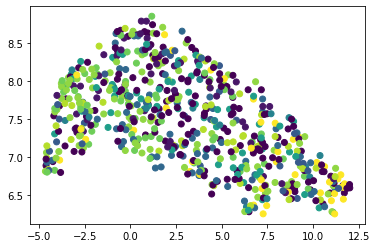

In [95]:
x, y = zip(*frequent_umap_components)
plt.scatter(x, y, c=frequent_label)

## Conclusion: the tested autoencoder embeddings are not good